In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import numpy as np
from scipy.io import loadmat, savemat
import sys
import src.config as cfg
import src.fitting as fit
import src.recon as recon
import visionloader as vl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from scipy import stats
import cv2
import jax
import jax.numpy as jnp
from stim_algos import GTDExperiment, DictionaryEntry
import estim_utils.triplet as triplet

%load_ext autoreload
%autoreload 2

In [2]:
FRAME_TIME = 1.5
STIM_TIME = 5e-5
REFRACTORY_DELAY = 200
GUARD_TIME = 0

In [3]:
def calculate_sig_stixels(sta, num_frames=9, alpha=1/10000, color_channels=None):
    """
    Sam Cooler sig stix implementation.

    Parameters:
        sta: STA of size t,y,x,c, with zero mean!
        num_frames: frames to use in noise calculation
        alpha: significance level
        color_channels: color channels to use
    Returns: tuple of booleans denoting the sig stix and the p values.
    
    Flips the STA and re-orders dims, but changes it back (doesn't mutate).

    """
    # Rearrange the dims and flip.
    sta = np.flip(np.moveaxis(sta,0,-2),axis=-2)

    if color_channels is None:
        color_channels = (0,1,2)

    early_frames = np.mean(sta[...,0:num_frames,color_channels], 3) 
    #std_this_cell = stats.median_absolute_deviation(early_frames.flatten())
    std_this_cell = stats.median_abs_deviation(early_frames.flatten())

    # Mean over color, square, sum over time
    input_frame = np.sum(np.power(np.mean(sta[...,-(num_frames+1):-1,
                               color_channels],3) / std_this_cell, 2), 2)

    # Chi squares survival = 1 - CDF
    pvalues = stats.chi2(df=num_frames).sf(input_frame) + np.finfo(float).eps 
    pvalues *= (sta.shape[0] * sta.shape[1]) # bonferroni correction

    # Put it back in order.
    sta = np.flip(np.moveaxis(sta,-2,0),axis=0)

    return pvalues < alpha, pvalues

## Get the gsorted cells

In [4]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
WNOISE_ANALYSIS_BASE = "/Volumes/Acquisition/Analysis"
dataset = "2023-10-30-0"
wnoise = "data000"
estim_neg = "data002"
outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)

vcd = vl.load_vision_data(os.path.join(WNOISE_ANALYSIS_BASE, dataset, wnoise),
                          os.path.basename(wnoise),
                          include_ei=True,
                          include_neurons=True,
                          include_params=True,
                          include_sta=True,
                          include_noise=True)
vcd.update_cell_type_classifications_from_text_file(os.path.join(WNOISE_ANALYSIS_BASE, dataset, wnoise, 
                                                                 'classification_deduped.txt'))

parameters = loadmat(os.path.join(outpath, 'parameters.mat'))
cells = parameters['cells'].flatten()
gsorted_cells = parameters['gsorted_cells'].flatten()

gsorted_cells_new = []
for i in range(len(gsorted_cells)):
    if 'on' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
        gsorted_cells_new.append(gsorted_cells[i])
    if 'off' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
        gsorted_cells_new.append(gsorted_cells[i])

gsorted_cells = np.array(gsorted_cells_new)
cells_to_use = cells[gsorted_cells]

## Constants

In [5]:
RESAMPLE_X = 320 # 80
RESAMPLE_Y = 160 # 40
ALPHA = 1e-10

In [6]:
N_SIGMAS_MASK = 2

In [7]:
stas = []
stas_fit = []
remove_cells = []

for cell in cells_to_use:
    sta = vcd.get_sta_for_cell(cell) 
    sta = np.stack([sta.red,sta.green,sta.blue])
    sta = np.swapaxes(sta,0,-1)
    
    # Resample the STA
    sta = np.asarray([cv2.resize(sta[i,...],(RESAMPLE_X,RESAMPLE_Y),interpolation=cv2.INTER_CUBIC)
           for i in range(sta.shape[0])
          ])
    sig_stix = calculate_sig_stixels(np.flip(sta,axis=0) - np.mean(sta),alpha=ALPHA)
    sta -= np.mean(sta)
    mask = sig_stix[0].astype(int)
    tc = np.sum(sta * mask[None,...,None],axis=(-1,-2,-3))
    sta = np.mean(sta[np.argmax(np.abs(tc)),...],axis=-1)
    
    # Fit 2d Gaussian.
    popt, pcov = fit.fit_gaussian2d(sta[...,None],np.argwhere(sig_stix[0]))
    
    if np.inf in np.absolute(pcov).flatten():
        remove_cells.append(cell)
        continue
        
    orig_n_pixels_x = sta.shape[1]
    orig_n_pixels_y = sta.shape[0]
    x = np.linspace(0,orig_n_pixels_x-1,RESAMPLE_X)
    y = np.linspace(0,orig_n_pixels_y-1,RESAMPLE_Y)
    xx,yy = np.meshgrid(x,y)
    out = fit.gaussian2d((xx,yy),*popt)
    out = recon.mask_gaussian_filter(out,popt,xx,yy,N_SIGMAS_MASK)
    stas_fit.append(out)
    stas.append(sta)
    
stas = np.asarray(stas)
stas_fit = np.asarray(stas_fit)

In [8]:
remove_cell_inds = np.searchsorted(cells_to_use, np.array(remove_cells))
gsorted_cells = np.setdiff1d(gsorted_cells, gsorted_cells[remove_cell_inds])
cells_to_use = np.setdiff1d(cells_to_use, np.array(remove_cells))

## Scale the STAs

In [9]:
FIRING_RATE = 2

In [10]:
try:
    encoding_filters = np.load(f'encoding_filters_{dataset}-onoff.npy')
except:
    encoding_filters = recon.get_encoding_filters_pooled(stas_fit,
                                                inds=[np.arange(0,stas.shape[0])],
                                                firing_rates=[FIRING_RATE],
                                                stixels=cfg.STIXEL_SIZES)
    np.save(f'encoding_filters_{dataset}-onoff.npy', encoding_filters)

## Compute reconstruction filters

In [ ]:
# Learn reconstruction filters together

try:
    decoding_filters = np.load(f'decoding_filters_{dataset}.npy')
except:
    decoding_filters = recon.learn_recon_filters_pooled(encoding_filters.reshape(-1,RESAMPLE_Y,RESAMPLE_X))
    np.save(f'decoding_filters_{dataset}.npy', decoding_filters)

In [11]:
# Learn reconstruction filters one cell at a time

try:
    decoding_filters = np.load(f'decoding_filters_{dataset}-onoff-{ALPHA}-individual.npy')
except:
    decoding_filters = recon.learn_recon_filters_pooled_individual(encoding_filters.reshape(-1,RESAMPLE_Y,RESAMPLE_X))
    np.save(f'decoding_filters_{dataset}-onoff-{ALPHA}-individual.npy', decoding_filters)

In [12]:
encoding_filters.shape, decoding_filters.shape

((126, 51200), (126, 51200))

In [ ]:
for i in range(encoding_filters.shape[0]):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(encoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')

    plt.tight_layout()
    plt.show()

    # plt.figure()
    # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
    # plt.xlim(xlim)
    # plt.title(f'{vcd.get_cell_type_for_cell(cells_to_use[i])} {cells_to_use[i]}', fontsize=24)
    # plt.axis('off')
    # plt.savefig(f'decoding_filter_example-{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.show()
    input()

## we do greedy ..

In [13]:
mask = (np.sum(np.abs(encoding_filters),axis=0)!=0).astype(int)
sig_stix = np.argwhere(mask).flatten()

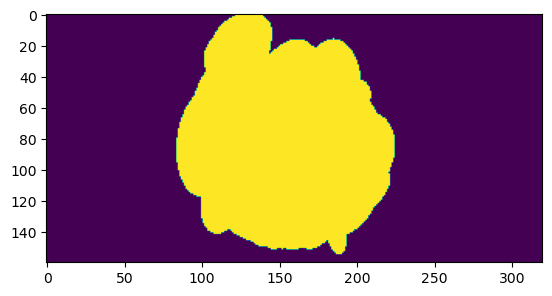

In [14]:
plt.imshow(mask.reshape(160,320))

In [15]:
xlim = [70, 250]

In [16]:
dict_data_1elec = loadmat(f'estim_dictionary_1elec_{dataset}-onoff.mat', squeeze_me=True, 
                          struct_as_record=False)
dictionary_matrix = dict_data_1elec['dictionary_matrix']
dictionary_matrix = dictionary_matrix[:, np.setdiff1d(np.arange(dictionary_matrix.shape[1], dtype=int),
                                                      np.array(remove_cell_inds))]
electrodes_amplitudes = dict_data_1elec['EA']

In [17]:
dictionary_matrix.shape, decoding_filters.shape

((1073, 126), (126, 51200))

In [18]:
decoder = decoding_filters.reshape(decoding_filters.shape[0], 1, 160, 320)

dictionary_info = []
for entry in range(dictionary_matrix.shape[0]):
    dictionary_info.append(
        DictionaryEntry(
           electrodes= [electrodes_amplitudes[entry, 0]],
           pulses_indices=[electrodes_amplitudes[entry, 1]],
           num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
           )
        )

In [19]:
STIXEL_SIZE = 64

In [20]:
NUM_REPEATS = 100     # TODO: set this
error_map_avg = np.zeros(decoding_filters.shape[1])
signed_error_map_avg = np.zeros(decoding_filters.shape[1])

for i in range(NUM_REPEATS):
    print(f'Repeat {i+1}')
    
    visual_stimulus = recon.get_random_stimuli_jitter(1, STIXEL_SIZE, RESAMPLE_X, RESAMPLE_Y)
    visual_stimulus = visual_stimulus.reshape(1, 160, 320)

    # plt.figure()
    # plt.imshow(visual_stimulus[0] * mask.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    experiment_without_sm = GTDExperiment(
        dictionary=dictionary_matrix, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm = experiment_without_sm.run()
    masked_expt = experiment_without_sm.reconstruction[0].flatten() * mask

    # plt.figure()
    # plt.imshow(masked_expt.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    masked_stimulus = jnp.array(visual_stimulus[0].reshape(160*320, 1).ravel() * mask)
    masked_decoder = jnp.array((decoding_filters.T * mask[:, None]))

    losses, x = recon.get_optimal_recon_jax(masked_decoder, masked_stimulus, 
                                            jnp.array(np.absolute(np.random.normal(size=decoding_filters.shape[0]))),
                                            step_size=2, n_steps=1000, verbose=True, obj_tol=1e-5)

    # plt.figure()
    # plt.plot(losses)
    # plt.show()

    masked_opt = (decoding_filters.T @ x) * mask
    # plt.figure()
    # plt.imshow(masked_opt.reshape(160,320),cmap='gray', vmin=-1, vmax=1)
    # plt.xlim([70,250])
    # plt.show()

    error_map = (masked_opt - masked_expt)**2 / np.linalg.norm(visual_stimulus[0].ravel() * mask)**2
    signed_error_map = masked_opt - masked_expt

    error_map_avg += error_map
    signed_error_map_avg += signed_error_map

    # input()

error_map_avg = error_map_avg / NUM_REPEATS
signed_error_map_avg = signed_error_map_avg / NUM_REPEATS

Repeat 1

00001 / 29999 Stims6 / 29999 Stims
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266

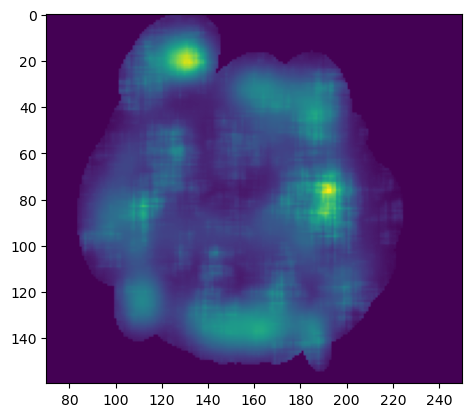

In [21]:
plt.figure()
plt.imshow(error_map_avg.reshape(160, 320))
plt.xlim([70,250])
plt.show()

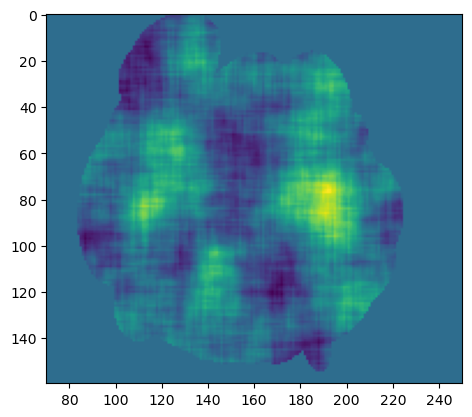

In [22]:
plt.figure()
plt.imshow(signed_error_map_avg.reshape(160, 320))
plt.xlim([70,250])
plt.show()

In [23]:
np.save(f'error_map_avg_{dataset}-onoff.npy', error_map_avg)
np.save(f'signed_error_map_avg_{dataset}-onoff.npy', signed_error_map_avg)

In [24]:
error_map_avg = np.load(f'error_map_avg_{dataset}-onoff.npy')
signed_error_map_avg = np.load(f'signed_error_map_avg_{dataset}-onoff.npy')

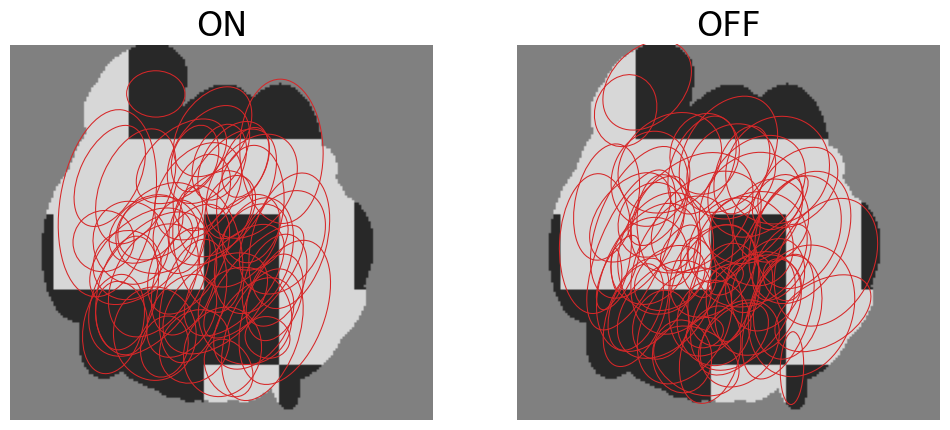

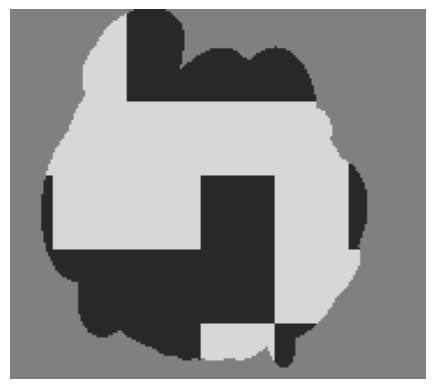

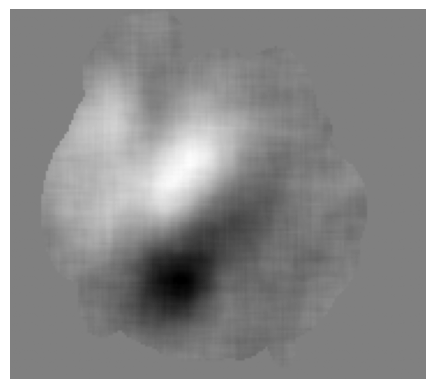

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

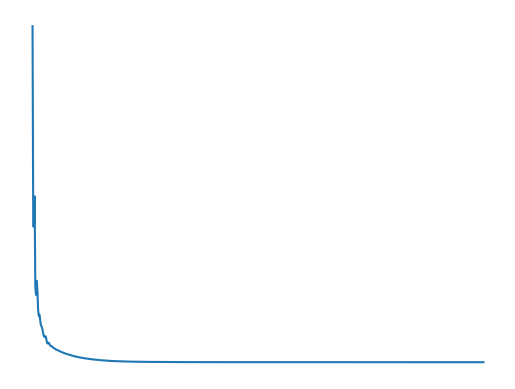

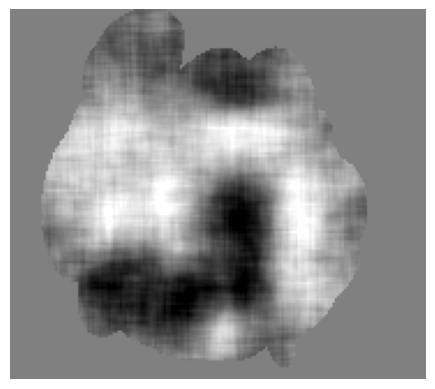

In [73]:
visual_stimulus = recon.get_random_stimuli_jitter(1, STIXEL_SIZE, RESAMPLE_X, RESAMPLE_Y)
visual_stimulus = visual_stimulus.reshape(1, 160, 320)
vmin = -0.7
vmax = 0.7

NUM_SIGMAS_RF_FIT = 4
CONVERSION_FACTOR = 4
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for cell in cells_to_use:
    # Get the STA fits. 
    sta_fit = vcd.get_stafit_for_cell(cell)
    mu_x = sta_fit.center_x * CONVERSION_FACTOR
    mu_y = sta_fit.center_y * CONVERSION_FACTOR
    sigma_y = sta_fit.std_x * CONVERSION_FACTOR
    sigma_x = sta_fit.std_y * CONVERSION_FACTOR
    degrees = sta_fit.rot * (180 / np.pi) * -1
    fit = Ellipse(xy = (mu_x,mu_y), width = NUM_SIGMAS_RF_FIT * sigma_y,
            height = NUM_SIGMAS_RF_FIT * sigma_x,
            angle = degrees,
            edgecolor='tab:red', facecolor='none', linewidth=0.75)

    if 'on' in vcd.get_cell_type_for_cell(cell).lower():
        # ax[ind+1].set(xlim=[0,(width-1)],ylim=[0,(height-1)],aspect=1)
        # ax[ind].set(xlim=[0,(width-1)],ylim=[(height-1),0],aspect=1)\
        ax[0].add_patch(fit)
        ax[0].set_xlim(xlim)
        # ax[0].set_ylim([0, 160])

    elif 'off' in vcd.get_cell_type_for_cell(cell).lower():
        # ax[ind+1].set(xlim=[0,(width-1)],ylim=[0,(height-1)],aspect=1)
        # ax[ind].set(xlim=[0,(width-1)],ylim=[(height-1),0],aspect=1)\
        ax[1].add_patch(fit)
        ax[1].set_xlim(xlim)
        # ax[1].set_ylim([0, 160])
ax[0].imshow(np.flip(visual_stimulus[0] * mask.reshape(160,320), axis=0),cmap='gray',
             vmin=vmin, vmax=vmax)
ax[1].imshow(np.flip(visual_stimulus[0] * mask.reshape(160,320), axis=0),cmap='gray',
             vmin=vmin, vmax=vmax)
ax[0].set_xlim(xlim)
ax[0].set_ylim([0, 160])
ax[1].set_xlim(xlim)
ax[1].set_ylim([0, 160])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('ON', fontsize=24)
ax[1].set_title('OFF', fontsize=24)
plt.savefig(f'mosaics_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

plt.figure()
plt.imshow(visual_stimulus[0] * mask.reshape(160,320),cmap='gray', vmin=vmin, vmax=vmax)
plt.xlim(xlim)
plt.axis('off')
plt.savefig(f'visual_stimulus_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

experiment_without_sm = GTDExperiment(
    dictionary=dictionary_matrix, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
    dictionary_info=dictionary_info, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
    visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
    visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
    frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
    stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
    refractory_delay = REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
    guard_time = GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
    )

print(flush=True)
#returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
sef_array_no_sm = experiment_without_sm.run()
masked_expt = experiment_without_sm.reconstruction[0].flatten() * mask

plt.figure()
plt.imshow(masked_expt.reshape(160,320),cmap='gray', vmin=vmin, vmax=vmax)
plt.xlim(xlim)
plt.axis('off')
plt.savefig(f'recon_1elec_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

masked_stimulus = jnp.array(visual_stimulus[0].reshape(160*320, 1).ravel() * mask)
masked_decoder = jnp.array((decoding_filters.T * mask[:, None]))

losses, x = recon.get_optimal_recon_jax(masked_decoder, masked_stimulus, 
                                        jnp.array(np.absolute(np.random.normal(size=decoding_filters.shape[0]))),
                                        step_size=2, n_steps=1000, verbose=True, obj_tol=1e-5)

plt.figure()
plt.plot(losses)
plt.axis('off')
plt.show()

masked_opt = (decoding_filters.T @ x) * mask
plt.figure()
plt.imshow(masked_opt.reshape(160,320),cmap='gray', vmin=vmin, vmax=vmax)
plt.xlim(xlim)
plt.axis('off')
plt.savefig(f'recon_optimal_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [74]:
cell_products = np.zeros(decoding_filters.shape[0])
for i in range(decoding_filters.shape[0]):
    # plt.figure()
    # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
    # plt.show()

    pixel_mask = (encoding_filters[i, :] != 0).astype(int)

    # plt.figure()
    # plt.imshow((decoding_filters[i, :] * pixel_mask).reshape(160, 320), cmap='gray')
    # plt.show()

    cell_products[i] = ((decoding_filters[i, :] * pixel_mask)**2 @ error_map_avg / 
                         (np.linalg.norm(error_map_avg) * np.linalg.norm((decoding_filters[i, :] * pixel_mask)**2)))

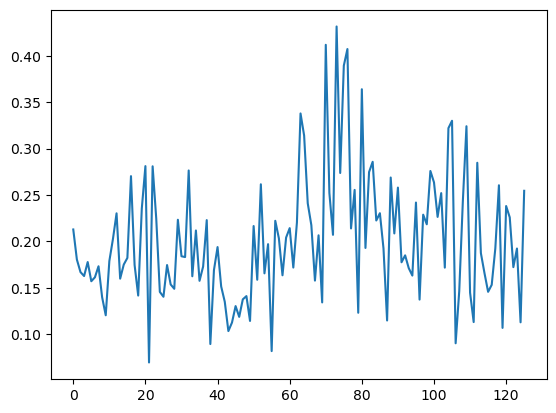

In [75]:
plt.figure()
plt.plot(cell_products)

In [76]:
def get_selectivity(dictionary):
    selectivities = np.zeros(len(dictionary))
    for i in range(len(dictionary)):
        selectivity_elements = dictionary[i, :] * np.multiply.reduce(
            (1 - dictionary[np.setdiff1d(np.arange(len(dictionary), dtype=int), i), :]),
            axis=0)

        selectivities[i] = np.amax(selectivity_elements)

    return selectivities

[ 73  70  76  75  80  63 105 109 104  64]


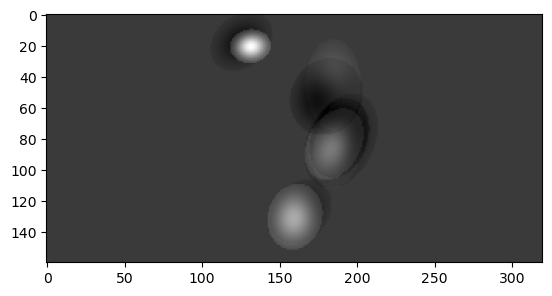

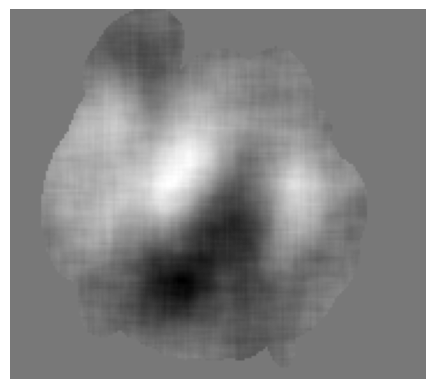

[ 73  70  76  75  80  63 105 109 104  64  83 112  20  22  32  99  82  74
  16  88 100  52 118  90  78 125  71 102 108  95]


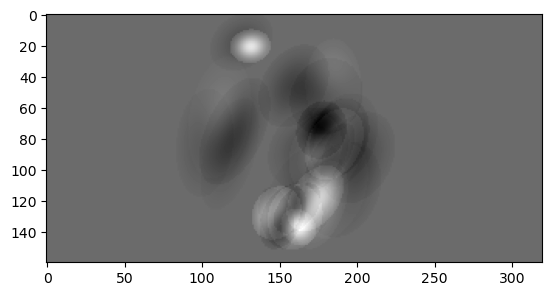

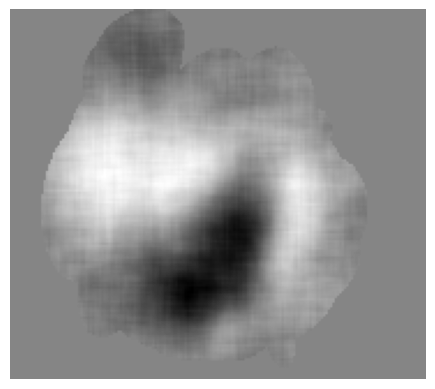

[ 73  70  76  75  80  63 105 109 104  64  83 112  20  22  32  99  82  74
  16  88 100  52 118  90  78 125  71 102 108  95  65 120  19  85  12  97
 101 121  23  29  37  84  56  62  98  66  50  60  77   0]


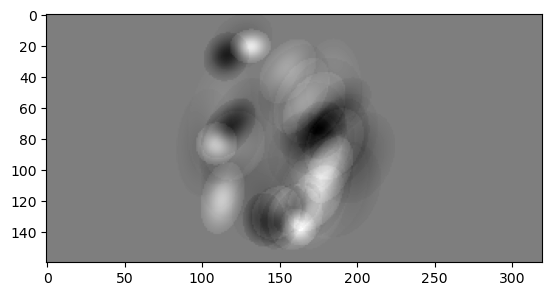

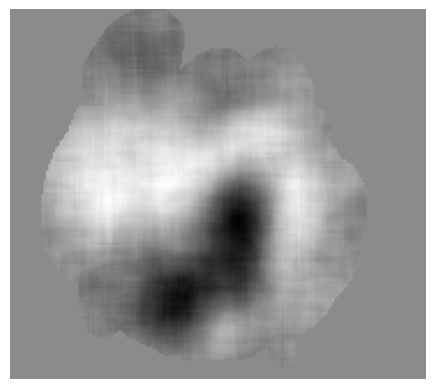

[ 73  70  76  75  80  63 105 109 104  64  83 112  20  22  32  99  82  74
  16  88 100  52 118  90  78 125  71 102 108  95  65 120  19  85  12  97
 101 121  23  29  37  84  56  62  98  66  50  60  77   0  34  89  72  68
  59  57  11  54  40  81 117  86 123 113  92  30  31  15   1  10]


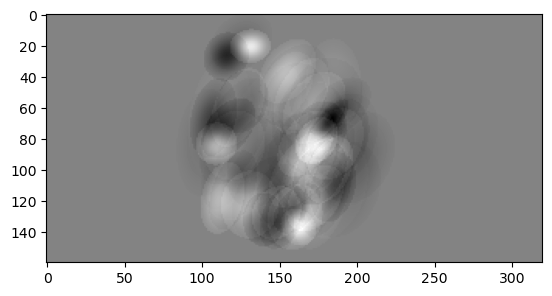

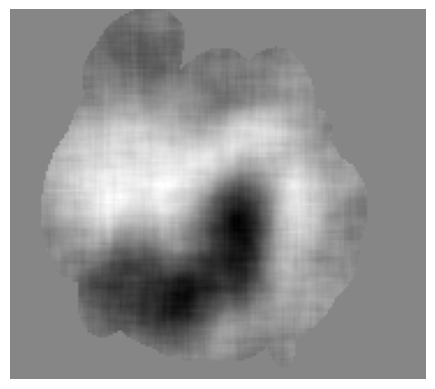

[ 73  70  76  75  80  63 105 109 104  64  83 112  20  22  32  99  82  74
  16  88 100  52 118  90  78 125  71 102 108  95  65 120  19  85  12  97
 101 121  23  29  37  84  56  62  98  66  50  60  77   0  34  89  72  68
  59  57  11  54  40  81 117  86 123 113  92  30  31  15   1  10   4  91
  14  17  26   7  36 122  61 103  93  39   2 114  53  58  94   3  33   6]


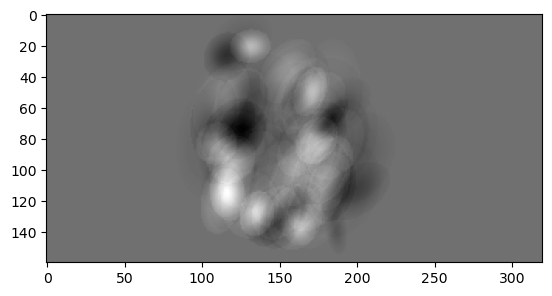

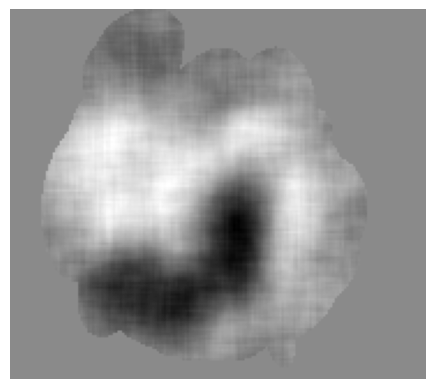

[ 73  70  76  75  80  63 105 109 104  64  83 112  20  22  32  99  82  74
  16  88 100  52 118  90  78 125  71 102 108  95  65 120  19  85  12  97
 101 121  23  29  37  84  56  62  98  66  50  60  77   0  34  89  72  68
  59  57  11  54  40  81 117  86 123 113  92  30  31  15   1  10   4  91
  14  17  26   7  36 122  61 103  93  39   2 114  53  58  94   3  33   6
  13  51  67  35   5  27 116  41  28 107 115  24 110  18  48  25   8  47
  96  42]


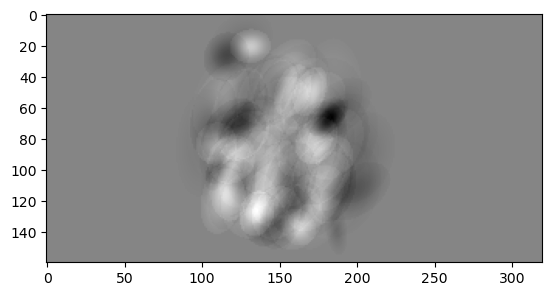

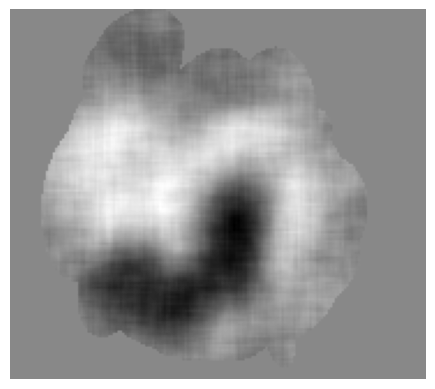

[ 73  70  76  75  80  63 105 109 104  64  83 112  20  22  32  99  82  74
  16  88 100  52 118  90  78 125  71 102 108  95  65 120  19  85  12  97
 101 121  23  29  37  84  56  62  98  66  50  60  77   0  34  89  72  68
  59  57  11  54  40  81 117  86 123 113  92  30  31  15   1  10   4  91
  14  17  26   7  36 122  61 103  93  39   2 114  53  58  94   3  33   6
  13  51  67  35   5  27 116  41  28 107 115  24 110  18  48  25   8  47
  96  42  69  45  79   9  46  87  49 111 124  44 119  43 106  38  55  21]


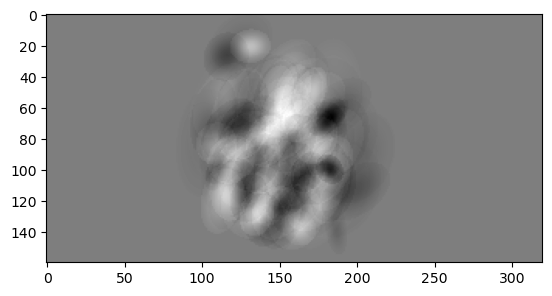

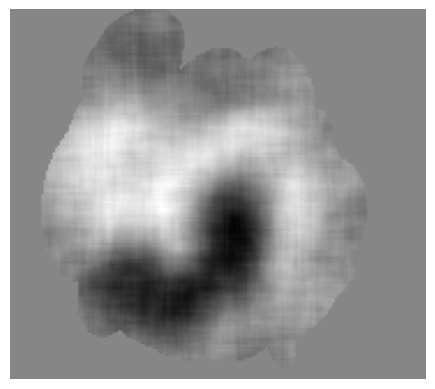

[ 73  70  76  75  80  63 105 109 104  64  83 112  20  22  32  99  82  74
  16  88 100  52 118  90  78 125  71 102 108  95  65 120  19  85  12  97
 101 121  23  29  37  84  56  62  98  66  50  60  77   0  34  89  72  68
  59  57  11  54  40  81 117  86 123 113  92  30  31  15   1  10   4  91
  14  17  26   7  36 122  61 103  93  39   2 114  53  58  94   3  33   6
  13  51  67  35   5  27 116  41  28 107 115  24 110  18  48  25   8  47
  96  42  69  45  79   9  46  87  49 111 124  44 119  43 106  38  55  21]


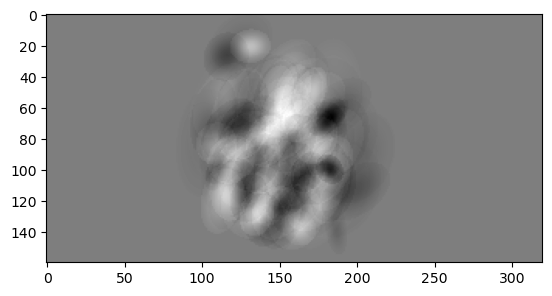

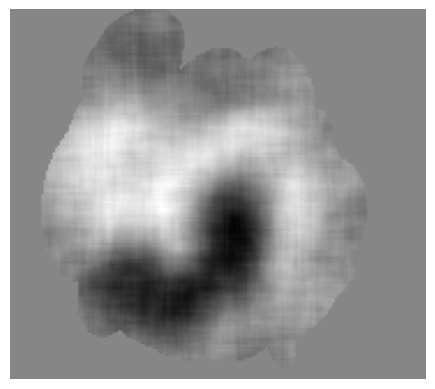

In [77]:
error_list = []
num_cells_list = [10, 30, 50, 70, 90, 110, 130, 150]
num_cells_with_high_sel = []
sel_thresh = 0.95
num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix.T) > sel_thresh))

for j in range(len(num_cells_list)):
    num_cells = num_cells_list[j]
    bad_cell_inds = np.flip(np.argsort(cell_products))[:num_cells]
    print(bad_cell_inds)

    bad_superimposed = np.zeros(encoding_filters.shape[1])
    for i in bad_cell_inds:
        bad_superimposed += encoding_filters[i, :]

    plt.figure()
    plt.imshow(bad_superimposed.reshape(160, 320), cmap='gray')
    plt.show()

    augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[1]))
    augmented_EA = np.zeros((len(bad_cell_inds), 2))
    for i in range(len(bad_cell_inds)):
        augmented_entries[i, bad_cell_inds[i]] = 1
        augmented_EA[i, 0] = 519 + i
        augmented_EA[i, 1] = 30

    dictionary_matrix_aug = np.vstack((dictionary_matrix, augmented_entries))
    electrodes_amplitudes_aug = np.vstack((electrodes_amplitudes, augmented_EA))

    num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix_aug.T) > sel_thresh))

    dictionary_info_aug = []
    for entry in range(dictionary_matrix_aug.shape[0]):
        dictionary_info_aug.append(
            DictionaryEntry(
            electrodes= [electrodes_amplitudes_aug[entry, 0]],
            pulses_indices=[electrodes_amplitudes_aug[entry, 1]],
            num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
            )
            )
        
    experiment_without_sm_aug = GTDExperiment(
        dictionary=dictionary_matrix_aug, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info_aug, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm_aug = experiment_without_sm_aug.run()
    masked_aug = experiment_without_sm_aug.reconstruction[0].flatten() * mask

    plt.figure()
    plt.imshow(masked_aug.reshape(160,320),cmap='gray')
    plt.xlim([70,250])
    plt.axis('off')
    plt.savefig(f'recon_augmented{num_cells}_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    
    error_list.append(experiment_without_sm_aug.compute_reconstruction_mse())

In [78]:
num_cells_with_high_sel, num_cells_list

([10, 19, 38, 57, 75, 92, 110, 126, 126], [10, 30, 50, 70, 90, 110, 130, 150])

In [79]:
cell_products_signed = np.zeros(decoding_filters.shape[0])
for i in range(decoding_filters.shape[0]):
    # plt.figure()
    # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
    # plt.show()

    pixel_mask = (encoding_filters[i, :] != 0).astype(int)

    # plt.figure()
    # plt.imshow((decoding_filters[i, :] * pixel_mask).reshape(160, 320), cmap='gray')
    # plt.show()

    cell_products_signed[i] = (decoding_filters[i, :] * pixel_mask) @ signed_error_map_avg 

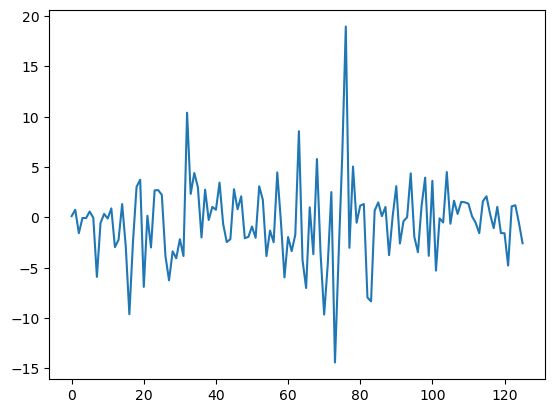

In [80]:
plt.figure()
plt.plot(cell_products_signed)

[ 76  32  63  75  68  78 104  57  34  94]


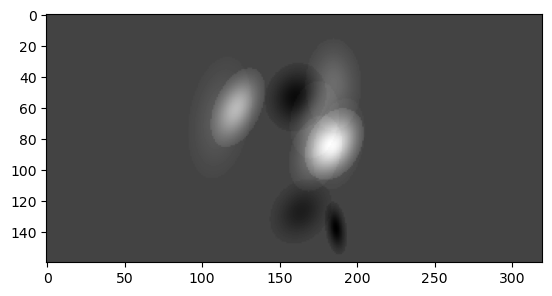

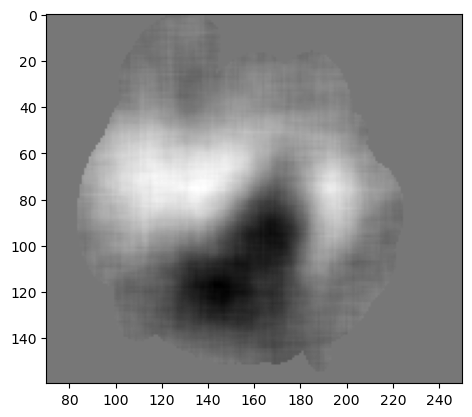

[ 76  32  63  75  68  78 104  57  34  94  98  19 100  41  90  52  18  35
  45  37  24  23  72  33  25 115  47  53 106 114]


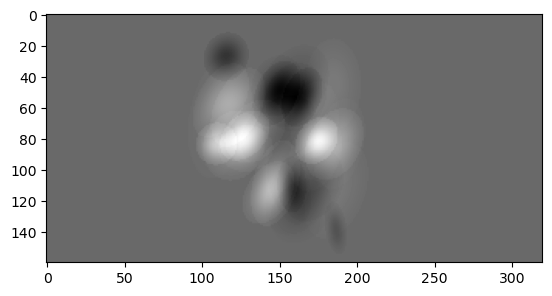

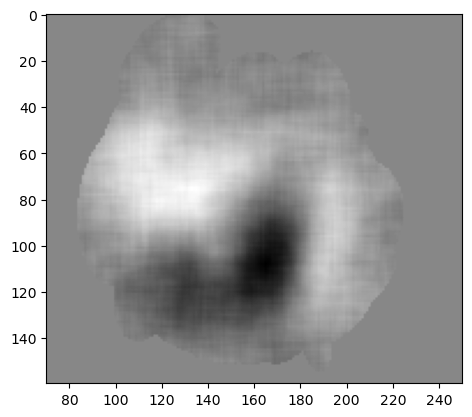

[ 76  32  63  75  68  78 104  57  34  94  98  19 100  41  90  52  18  35
  45  37  24  23  72  33  25 115  47  53 106 114 108 109  85 110  81  14
 123  80  97 122 118  39  87  66  11  46  40   1  84   5]


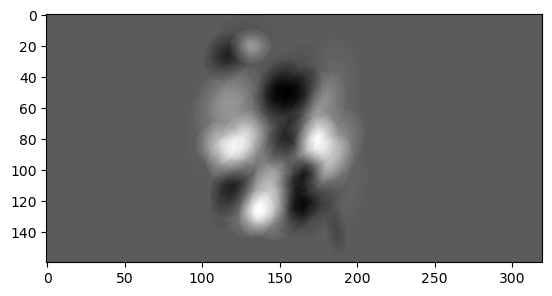

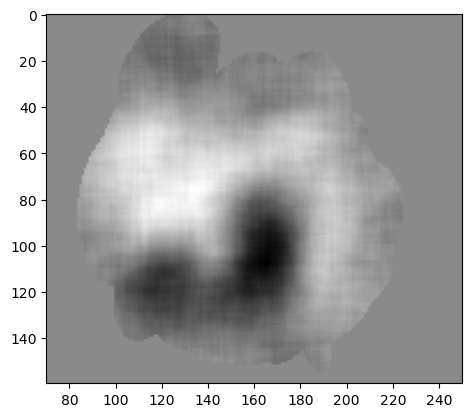

[ 76  32  63  75  68  78 104  57  34  94  98  19 100  41  90  52  18  35
  45  37  24  23  72  33  25 115  47  53 106 114 108 109  85 110  81  14
 123  80  97 122 118  39  87  66  11  46  40   1  84   5   9 107 116  21
  89   0  86 111  93   6   3   4 102  10  38  58  92 103  79 112]


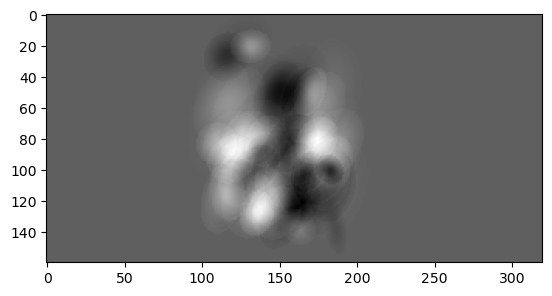

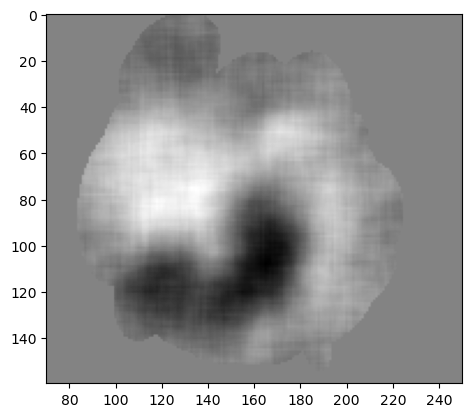

[ 76  32  63  75  68  78 104  57  34  94  98  19 100  41  90  52  18  35
  45  37  24  23  72  33  25 115  47  53 106 114 108 109  85 110  81  14
 123  80  97 122 118  39  87  66  11  46  40   1  84   5   9 107 116  21
  89   0  86 111  93   6   3   4 102  10  38  58  92 103  79 112 124   8
 105  42  50 117  55 119   2 113 120  62  49  95  60  36  51  48  44  30]


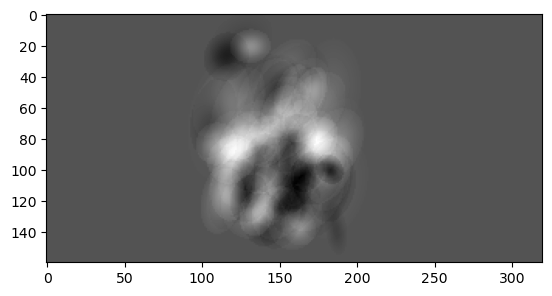

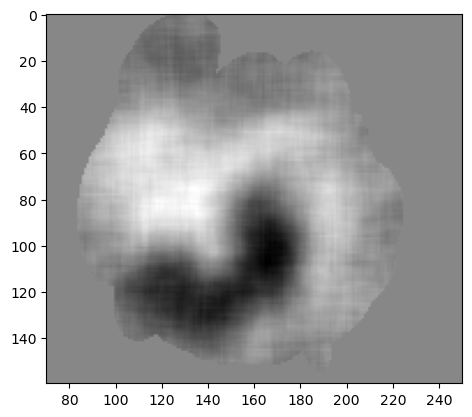

[ 76  32  63  75  68  78 104  57  34  94  98  19 100  41  90  52  18  35
  45  37  24  23  72  33  25 115  47  53 106 114 108 109  85 110  81  14
 123  80  97 122 118  39  87  66  11  46  40   1  84   5   9 107 116  21
  89   0  86 111  93   6   3   4 102  10  38  58  92 103  79 112 124   8
 105  42  50 117  55 119   2 113 120  62  49  95  60  36  51  48  44  30
  13  43  17  56 125  91  15  12  22  77  61  28  96  69  67  88  99  26
  31  54]


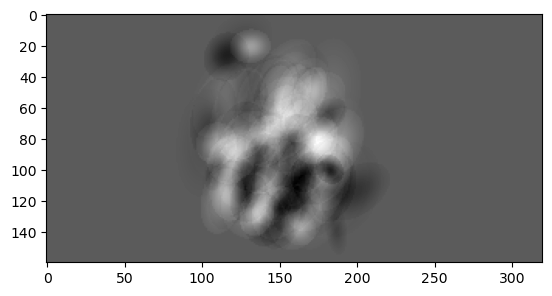

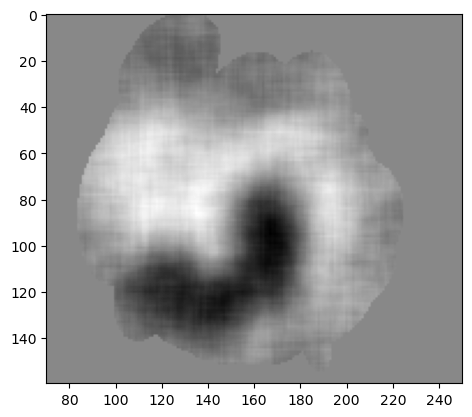

[ 76  32  63  75  68  78 104  57  34  94  98  19 100  41  90  52  18  35
  45  37  24  23  72  33  25 115  47  53 106 114 108 109  85 110  81  14
 123  80  97 122 118  39  87  66  11  46  40   1  84   5   9 107 116  21
  89   0  86 111  93   6   3   4 102  10  38  58  92 103  79 112 124   8
 105  42  50 117  55 119   2 113 120  62  49  95  60  36  51  48  44  30
  13  43  17  56 125  91  15  12  22  77  61  28  96  69  67  88  99  26
  31  54  74  29  64  71 121 101   7  59  27  20  65  82  83  16  70  73]


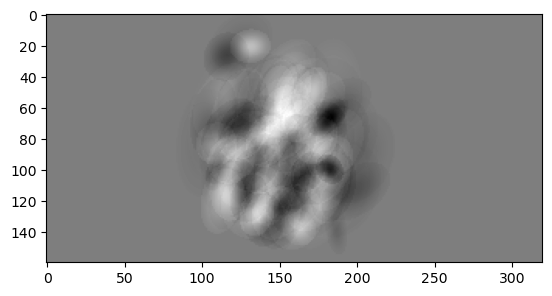

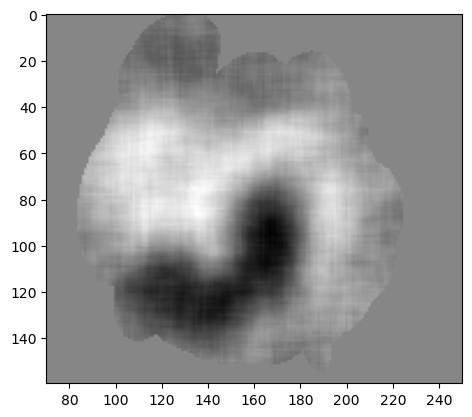

[ 76  32  63  75  68  78 104  57  34  94  98  19 100  41  90  52  18  35
  45  37  24  23  72  33  25 115  47  53 106 114 108 109  85 110  81  14
 123  80  97 122 118  39  87  66  11  46  40   1  84   5   9 107 116  21
  89   0  86 111  93   6   3   4 102  10  38  58  92 103  79 112 124   8
 105  42  50 117  55 119   2 113 120  62  49  95  60  36  51  48  44  30
  13  43  17  56 125  91  15  12  22  77  61  28  96  69  67  88  99  26
  31  54  74  29  64  71 121 101   7  59  27  20  65  82  83  16  70  73]


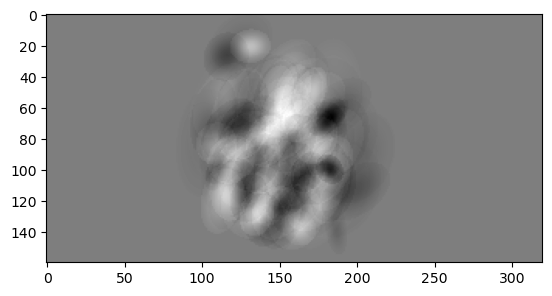

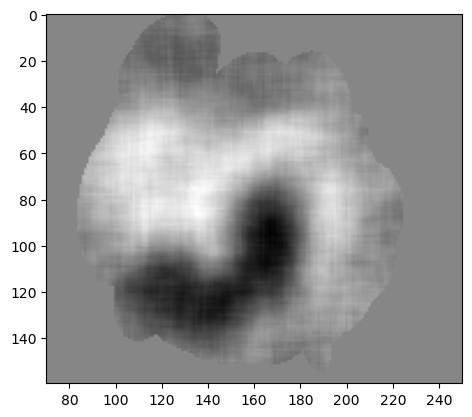

In [81]:
error_list_signed = []
# num_cells_with_high_sel = []
# sel_thresh = 0.95
# num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix.T) > sel_thresh))

for j in range(len(num_cells_list)):
    num_cells = num_cells_list[j]
    bad_cell_inds = np.flip(np.argsort(cell_products_signed))[:num_cells]
    print(bad_cell_inds)

    bad_superimposed = np.zeros(encoding_filters.shape[1])
    for i in bad_cell_inds:
        bad_superimposed += encoding_filters[i, :]

    plt.figure()
    plt.imshow(bad_superimposed.reshape(160, 320), cmap='gray')
    plt.show()

    augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[1]))
    augmented_EA = np.zeros((len(bad_cell_inds), 2))
    for i in range(len(bad_cell_inds)):
        augmented_entries[i, bad_cell_inds[i]] = 1
        augmented_EA[i, 0] = 519 + i
        augmented_EA[i, 1] = 30

    dictionary_matrix_aug = np.vstack((dictionary_matrix, augmented_entries))
    electrodes_amplitudes_aug = np.vstack((electrodes_amplitudes, augmented_EA))

    # num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix_aug.T) > sel_thresh))

    dictionary_info_aug = []
    for entry in range(dictionary_matrix_aug.shape[0]):
        dictionary_info_aug.append(
            DictionaryEntry(
            electrodes= [electrodes_amplitudes_aug[entry, 0]],
            pulses_indices=[electrodes_amplitudes_aug[entry, 1]],
            num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
            )
            )
        
    experiment_without_sm_aug = GTDExperiment(
        dictionary=dictionary_matrix_aug, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info_aug, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm_aug = experiment_without_sm_aug.run()
    masked_aug = experiment_without_sm_aug.reconstruction[0].flatten() * mask

    plt.figure()
    plt.imshow(masked_aug.reshape(160,320),cmap='gray')
    plt.xlim([70,250])
    plt.show()
    
    error_list_signed.append(experiment_without_sm_aug.compute_reconstruction_mse())

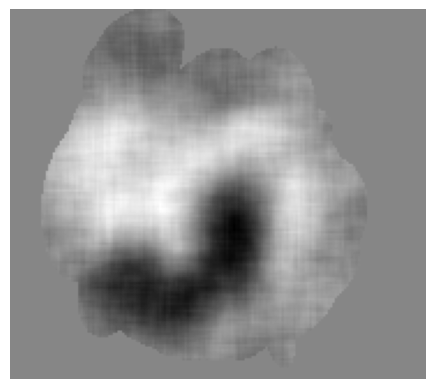

In [82]:
dictionary_matrix_sel = np.eye(len(gsorted_cells))

electrodes_amplitudes_sel = np.zeros((len(dictionary_matrix_sel), 2))
for i in range(len(dictionary_matrix_sel)):
    electrodes_amplitudes_sel[i, 0] = 519 + i
    electrodes_amplitudes_sel[i, 1] = 30

dictionary_info_sel = []
for entry in range(dictionary_matrix_sel.shape[0]):
    dictionary_info_sel.append(
        DictionaryEntry(
           electrodes= [electrodes_amplitudes_sel[entry, 0]],
           pulses_indices=[electrodes_amplitudes_sel[entry, 1]],
           num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
           )
        )

experiment_without_sm_sel = GTDExperiment(
    dictionary=dictionary_matrix_sel, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
    dictionary_info=dictionary_info_sel, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
    visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
    visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
    frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
    stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
    refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
    guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
    )

print(flush=True)
#returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
sef_array_no_sm_sel = experiment_without_sm_sel.run()
masked_sel = experiment_without_sm_sel.reconstruction[0].flatten() * mask

plt.figure()
plt.imshow(masked_sel.reshape(160,320),cmap='gray')
plt.xlim(xlim)
plt.axis('off')
plt.savefig(f'recon_selective_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [83]:
base_err = experiment_without_sm.compute_reconstruction_mse()
opt_err = recon.n_mse(visual_stimulus.flatten()[..., None], 
                      masked_opt[..., None], sig_stix)
sel_err = experiment_without_sm_sel.compute_reconstruction_mse()

In [84]:
base_err, opt_err, sel_err

(0.7310748617584917, array([0.36484373]), 0.448883849432445)

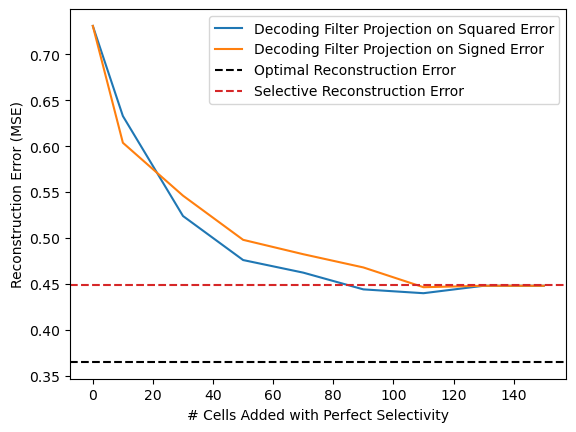

In [85]:
plt.figure()
plt.plot([0] + num_cells_list, [base_err] + error_list,
         label='Decoding Filter Projection on Squared Error')
plt.plot([0] + num_cells_list, [base_err] + error_list_signed,
         label='Decoding Filter Projection on Signed Error')
plt.axhline(opt_err, linestyle='--', c='k', label='Optimal Reconstruction Error')
plt.axhline(sel_err, linestyle='--', c='tab:red', label='Selective Reconstruction Error')
plt.xlabel('# Cells Added with Perfect Selectivity')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.show()

In [64]:
def get_significant_electrodes(vcd, cell_no, thr_factor):
    cell_ei = vcd.get_ei_for_cell(cell_no).ei
    collapsed_ei = np.amin(cell_ei, axis=1)
    channel_noise = vcd.channel_noise
    significant_electrodes = np.argwhere(np.abs(collapsed_ei) > thr_factor * channel_noise).flatten()
    return significant_electrodes, np.abs(collapsed_ei)

In [65]:
def split_cell_into_triplets(vcd: vl.VisionCellDataTable, cell_no: int, min_significant_electrodes: int, thr_factor: float,
                             verbose=False):
    good_inds, collapsed_ei = get_significant_electrodes(vcd, cell_no, thr_factor)
    significant_electrodes = good_inds + 1
    if verbose:
        print(significant_electrodes)
        
    if len(significant_electrodes) > 0:
        triplet_electrodes = np.array(triplet.TRIPLET_RECORD_ELECTRODES_519)
        num_elecs_per_triplet = np.count_nonzero(np.isin(triplet_electrodes, significant_electrodes).astype(int), axis=1)
        triplet_indices = np.where(num_elecs_per_triplet >= min_significant_electrodes)[0]
        
        if verbose:
            good_inds_plot, _ = get_significant_electrodes(vcd, cell_no, 1)
            coords = vcd.electrode_map
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.scatter(coords[:, 0], coords[:, 1], s=1, c="k")
            ax.scatter(coords[good_inds_plot, 0], coords[good_inds_plot, 1], s=collapsed_ei[good_inds_plot], c='tab:blue')
            plt.title(vcd.get_cell_type_for_cell(cell_no) + " " + str(cell_no), fontsize=22)

            for i, txt in enumerate(good_inds_plot):
                ax.annotate(txt+1, (coords[good_inds_plot[i], 0], coords[good_inds_plot[i], 1]), fontsize=6)
            for i, txt in enumerate(good_inds): 
                ax.annotate(txt+1, (coords[good_inds[i], 0], coords[good_inds[i], 1]), fontsize=6, color='r') 
                
            plt.show()

            print(len(triplet_indices))
            print(triplet.TRIPLET_RECORD_ELECTRODES_519[triplet_indices])
        
        return triplet_indices
    else:
        return np.array([])

In [66]:
def get_triplets(vcd: vl.VisionCellDataTable, cell_list: list, n : int, min_significant_electrodes: int, thr_factor, verbose=False):
    total_triplet_indices = []
    for i in range(n):
        total_triplet_indices.append(split_cell_into_triplets(vcd, cell_list[i], min_significant_electrodes, thr_factor, verbose=verbose))
    _, idx = np.unique(np.concatenate(total_triplet_indices), return_index=True)
    return np.concatenate(total_triplet_indices)[np.sort(idx)].astype(int)

In [45]:
all_triplets = get_triplets(vcd, cells_to_use[np.flip(np.argsort(cell_products_signed))], 120, 3, 4, verbose=False)

In [69]:
len(all_triplets), len(all_triplets) * 10 * 11**3 * 0.01 / 60 / 60

(138, 5.102166666666666)

In [47]:
all_triplets

array([248, 255, 578, 595, 608, 610, 620, 708, 725, 753, 763, 404, 420,
       421, 422, 423, 424, 844, 845, 858, 874, 876, 877, 685, 686, 776,
       777, 796, 834, 636, 661, 923, 924, 882, 884, 885, 310, 313, 329,
       330,  83,  85,  86, 295, 296, 297, 298, 300, 312, 314, 315, 316,
       317, 319, 333, 335, 336, 715, 716, 764,  33,  39,  91,  93, 120,
       783,  55, 359, 360, 362, 384, 385, 386, 861, 433, 739, 746, 278,
       290, 292, 448, 450, 451, 453, 467, 469, 470, 509,  84,  87,  95,
       100, 103, 594, 602, 611, 465, 466, 468, 476, 478, 479, 480, 484,
       457, 700, 710, 718, 406, 426, 551, 552, 584, 585, 592, 601, 494,
       495, 496, 914, 915, 916, 917, 925, 187, 188, 193, 194, 197, 203,
       205, 206, 209, 210, 219, 221, 228, 229])

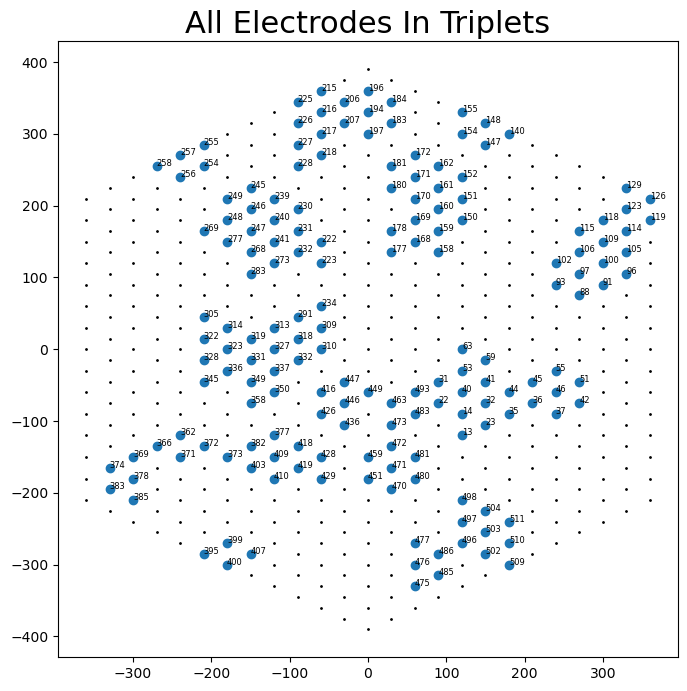

In [48]:
all_electrodes = np.unique(triplet.TRIPLET_RECORD_ELECTRODES_519[all_triplets].flatten())
electrode_inds = all_electrodes - 1
coords = vcd.electrode_map
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(coords[:, 0], coords[:, 1], s=1, c="k")

ax.scatter(coords[electrode_inds, 0], coords[electrode_inds, 1], c='tab:blue')
plt.title("All Electrodes In Triplets", fontsize=22)

for i, txt in enumerate(electrode_inds):
    ax.annotate(txt+1, (coords[electrode_inds[i], 0], coords[electrode_inds[i], 1]), fontsize=6)

plt.show()

In [49]:
def split_array(arr, N):
    """
    Split a 2D numpy array into blocks of at most N rows.
    
    Parameters:
    - arr (np.array): 2D numpy array to split.
    - N (int): Maximum number of rows in each block.

    Returns:
    - List of numpy arrays.
    """
    
    num_rows = arr.shape[0]
    return [arr[i:i+N] for i in range(0, num_rows, N)]

In [50]:
BLOCK_SIZE = 30
split_all_triplets = split_array(triplet.TRIPLET_RECORD_ELECTRODES_519[all_triplets], BLOCK_SIZE)
for i in range(len(split_all_triplets)):
    savemat(f'/Volumes/Lab/Users/praful/stim-rewrite/scans/triplets_output_{dataset}_{i}.mat', 
            {'electrodePairs': split_all_triplets[i],
             'channelPairs': np.zeros(split_all_triplets[i].shape)})